In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator
from torchtext.vocab import GloVe

from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import BinaryPrecision
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay

import math
from string import digits

import time

In [3]:
df = pd.read_csv("data/ML_text_data_new.csv")

In [4]:
def clean_text(text):
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = text.replace("HOUSE BILL", "")
    text = text.replace("SENATE BILL", "")
    text = re.sub(" {2,}", " ", text)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    return text

In [5]:
df['clean_text'] = df['text'].apply(lambda x: clean_text(x))

In [6]:
len(df)

2660

In [7]:
data = zip(df['discriminatory'], df['text'])

In [8]:
from string import digits

In [9]:
def clean_text(text):
    text = text.replace("\n", " ")
    text = text.replace("New Text Underlined", "")
    text = text.replace("[DELETED TEXT BRACKETED]", "")
    text = re.sub(" {2,}", " ", text)
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)

    return text

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        text = clean_text(text)
        text = tokenizer(text)
        yield text

In [12]:
vocab = build_vocab_from_iterator(
    yield_tokens(data), specials=["<unk>"], min_freq=100)

In [13]:
vocab.set_default_index(vocab["<unk>"])

In [14]:
# Checking the result
print(len(vocab))
print(vocab.lookup_token(0))
print(vocab.lookup_token(15))
print(vocab["bill"])
print(vocab["gender"])
print(vocab["pronoun"])
print(vocab["transgender"])

4013
<unk>
is
99
163
2432
3614


In [15]:
#truncate bills
data = zip(df['discriminatory'], df['text'])
data_list = [(label, tokens) for (label, tokens) in data] 
data_list[0]

(0,
 '  Enrolled HB  LAWS OF ALASKA            Source Chapter No.  CSHB (FIN) _______        AN ACT    Making supplemental appropriati ons and other appropriations; ma king appropriations under  art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve  fund; and providing for  an effective date.     _______________     BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF ALASKA:      THE ACT FOLLOWS ON PAGE    -- Enrolled HB                        AN ACT     Making supplemental appropriati ons and other appropriations; ma king appropriations under   art. IX, sec. (c), Constitution of the State of Alaska, from the constitutional budget reserve   fund; and providing for  an effective date.   _______________   (SECTION  OF THIS ACT BEGINS ON PAGE )      CSHB (FIN), Sec.      -  -     * Section . The following appropriation items  are for operating expenditure s from the   general fund or other funds as set out in the fiscal year  budget summary for the   

In [16]:
#standardize bill length - truncate and pad
for i, (label, text) in enumerate(data_list):
    text = clean_text(text)
    tokens = tokenizer(text)
    if len(tokens) > 500:
        tokens = tokens[:500]
        data_list[i] = (label, tokens)
    else:
        pad_len = 500 - len(tokens)
        padding = ['<unk>'] * pad_len
        tokens = tokens + padding
        data_list[i] = (label, tokens)
    

In [17]:
def collate_fn(batch):
    labels = torch.tensor([x[0] for x in batch])
    words = [x[1] for x in batch]
    word_idxs = []
    for window in words:
        window_idxs = [vocab[word] for word in window]
        word_idxs.append(window_idxs)
    word_idxs = torch.tensor(word_idxs)
    return labels, word_idxs

In [18]:
class CNNClassifier(nn.ModuleList):

   def __init__(self,
                 embedding_dim,
                 sequence_len,
                 vocab_len, 
                 out_size,
                 stride,
                 dropout):       
      super(CNNClassifier, self).__init__()

      self.embedding_size = embedding_dim
      self.seq_len = sequence_len
      self.vocab_len = vocab_len
  
      # Dropout definition
      self.dropout = nn.Dropout(dropout)
      
      # CNN parameters definition
      # Kernel sizes
      self.kernel_1 = 2
      self.kernel_2 = 3
      self.kernel_3 = 4
      self.kernel_4 = 5
      
      # Output size for each convolution
      self.out_size = out_size
      # Number of strides for each convolution
      self.stride = stride
      
      # Embedding layer definition
      self.embedding = nn.Embedding(self.vocab_len + 1, self.embedding_size, padding_idx=0)
      
      # Convolution layers definition
      self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
      self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
      self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
      self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)
      
      # Max pooling layers definition
      self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
      self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
      self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
      self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
      
      # Fully connected layer definition
      self.fc = nn.Linear(self.in_features_fc(), 1)

   def in_features_fc(self):
      '''Calculates the number of output features after Convolution + Max pooling
         
      Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
      Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
      
      source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
      '''
      # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
      out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
      out_conv_1 = math.floor(out_conv_1)
      out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
      out_pool_1 = math.floor(out_pool_1)
      
      # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
      out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
      out_conv_2 = math.floor(out_conv_2)
      out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
      out_pool_2 = math.floor(out_pool_2)
      
      # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
      out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
      out_conv_3 = math.floor(out_conv_3)
      out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
      out_pool_3 = math.floor(out_pool_3)
      
      # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
      out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
      out_conv_4 = math.floor(out_conv_4)
      out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
      out_pool_4 = math.floor(out_pool_4)
      
      # Returns "flattened" vector (input for fully connected layer)
      return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
   
   def forward(self, x):

      # Sequence of tokes is filterd through an embedding layer
      x = self.embedding(x)
      
      # Convolution layer 1 is applied
      x1 = self.conv_1(x)
      x1 = torch.relu(x1)
      x1 = self.pool_1(x1)
      
      # Convolution layer 2 is applied
      x2 = self.conv_2(x)
      x2 = torch.relu((x2))
      x2 = self.pool_2(x2)
   
      # Convolution layer 3 is applied
      x3 = self.conv_3(x)
      x3 = torch.relu(x3)
      x3 = self.pool_3(x3)
      
      # Convolution layer 4 is applied
      x4 = self.conv_4(x)
      x4 = torch.relu(x4)
      x4 = self.pool_4(x4)
      
      # The output of each convolutional layer is concatenated into a unique vector
      union = torch.cat((x1, x2, x3, x4), 2)
      union = union.reshape(union.size(0), -1)

      # The "flattened" vector is passed through a fully connected layer
      out = self.fc(union)
      # Dropout is applied		
      out = self.dropout(out)
      # Activation function is applied
      out = torch.sigmoid(out)
      
      return out.squeeze()

In [18]:
model = CNNClassifier(embedding_dim = 64,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2,
                 dropout = 0.25)

In [19]:
loss_function = nn.CrossEntropyLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() 
    log_interval = 50

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label.type('torch.FloatTensor'))
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [20]:
def get_probabilites(dataloader):
    model.eval()
    y_list = []
    y_pred_list = []
    with torch.no_grad(): 
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            y_list.append(label)
            y_pred_list.append(log_probs)
    y = torch.cat(y_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    return y, y_pred

In [21]:
def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():    
        total_acc, total_count = 0, 0
        all_recall = []
        all_precision = []
        recall_metric = BinaryRecall()
        precision_metric = BinaryPrecision()
        for idx, (label, word_idxs) in enumerate(dataloader):
            log_probs = model(word_idxs)
            total_acc += (log_probs.round() == label).sum().item()
            total_count += label.size(0)
            recall = recall_metric(log_probs, label)
            precision = precision_metric(log_probs, label)
            all_recall.append(recall)
            all_precision.append(precision)
    accuracy = total_acc/total_count

    return accuracy, np.mean(all_recall), np.mean(all_precision)

In [22]:
# Prep for data split
len_train = int(len(data_list) * .8)
len_valid = int((len(data_list) - len_train)/2)
len_test = len(data_list) - len_train - len_valid
print(len_train, "train", len_valid, "validation", len_test, "testing")

2128 train 266 validation 266 testing


In [26]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data_list, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 50 the loss is 19.231.
At iteration 100 the loss is 10.981.
Epoch: 1, time taken: 6.4s, validation accuracy: 
          0.327, recall: 0.981792688369751, precision: 0.306547611951828.
At iteration 50 the loss is 13.303.
At iteration 100 the loss is 18.966.
Epoch: 2, time taken: 7.1s, validation accuracy: 
          0.665, recall: 0.6390756964683533, precision: 0.4669467806816101.
At iteration 50 the loss is 18.239.
At iteration 100 the loss is 15.887.
Epoch: 3, time taken: 6.8s, validation accuracy: 
          0.767, recall: 0.4663865566253662, precision: 0.6823529601097107.
At iteration 50 the loss is 12.690.
At iteration 100 the loss is 2.185.
Epoch: 4, time taken: 5.9s, validation accuracy: 
          0.778, recall: 0.4399159550666809, precision: 0.7009804248809814.
At iteration 50 the loss is 17.916.
At iteration 100 the loss is 15.108.
Epoch: 5, time taken: 5.4s, validation accuracy: 
          0.797, recall: 0.5497198700904846, precision: 0.738725483417511.
At iterat

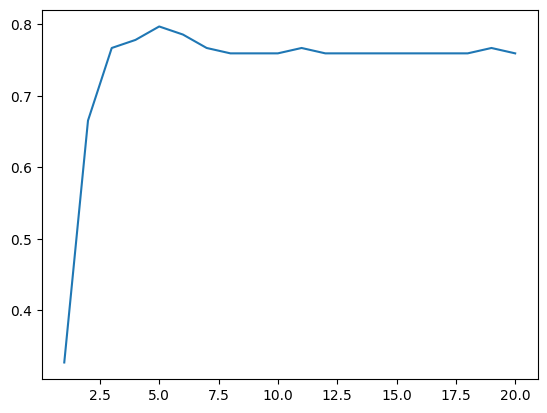

In [24]:
#CNN model train
import time
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 20 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

Text(0, 0.5, 'Accuracy')

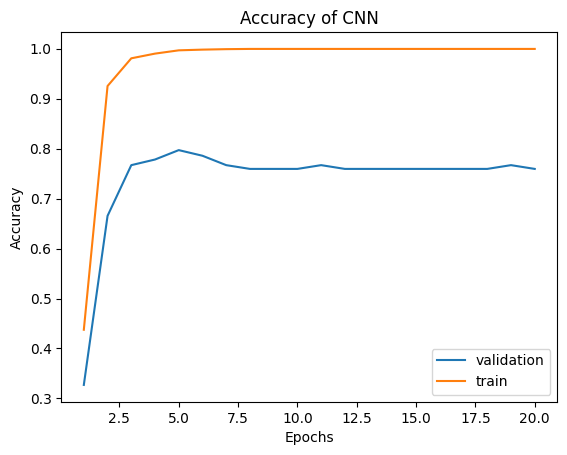

In [25]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Recall')

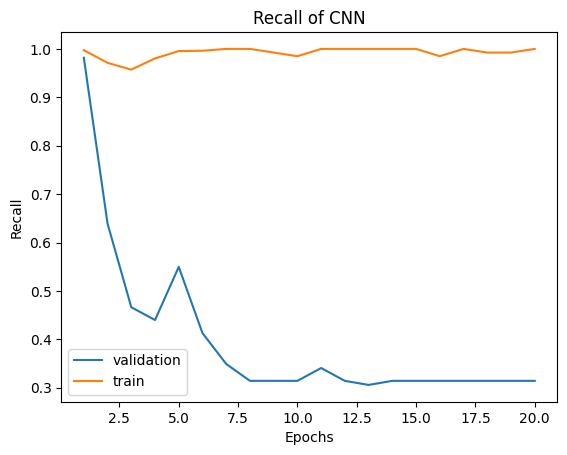

In [26]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')

Text(0, 0.5, 'Precision')

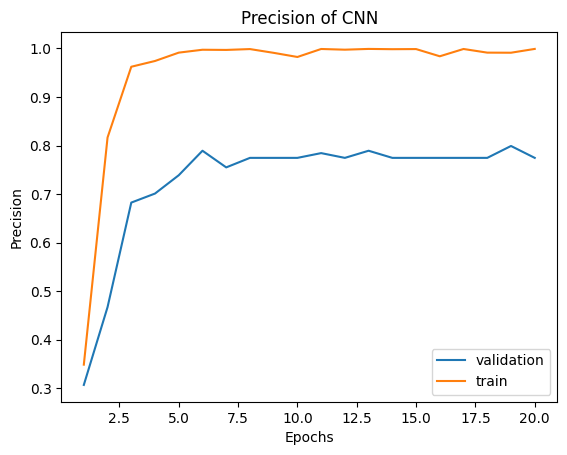

In [27]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')

In [28]:
#roc curve

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

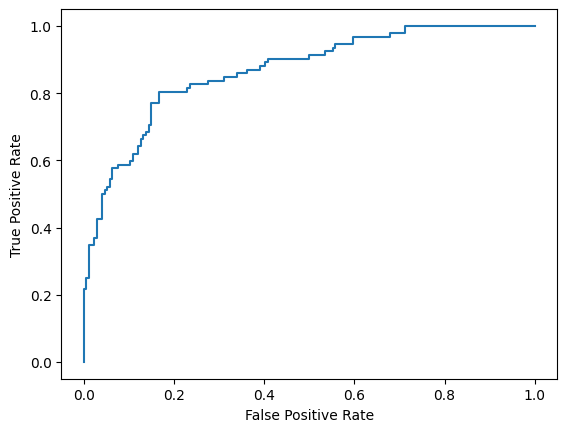

In [29]:
plot_roc_curve(y, y_prob)

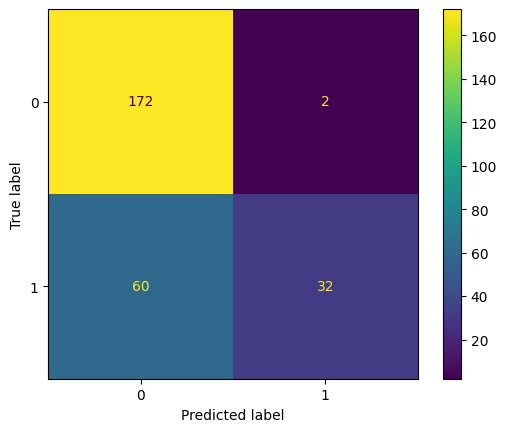

In [30]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()

In [31]:
model = CNNClassifier(embedding_dim = 64,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2,
                 dropout = 0.25)

In [32]:
BATCH_SIZE = 16

train_data, valid_data, test_data = random_split(
    data_list, [len_train, len_valid, len_test])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_fn)

At iteration 50 the loss is 13.818.
At iteration 100 the loss is 11.110.
Epoch: 1, time taken: 6.5s, validation accuracy: 
          0.286, recall: 1.0, precision: 0.2803921699523926.
At iteration 50 the loss is 18.884.
At iteration 100 the loss is 10.604.
Epoch: 2, time taken: 6.5s, validation accuracy: 
          0.752, recall: 0.556816041469574, precision: 0.6039215326309204.
At iteration 50 the loss is 15.278.
At iteration 100 the loss is 21.292.
Epoch: 3, time taken: 6.5s, validation accuracy: 
          0.801, recall: 0.44831931591033936, precision: 0.6803921461105347.
At iteration 50 the loss is 9.935.
At iteration 100 the loss is 14.978.
Epoch: 4, time taken: 6.5s, validation accuracy: 
          0.786, recall: 0.5489729642868042, precision: 0.7095237970352173.
At iteration 50 the loss is 17.715.
At iteration 100 the loss is 12.261.
Epoch: 5, time taken: 6.0s, validation accuracy: 
          0.816, recall: 0.472829133272171, precision: 0.8019607663154602.
The estimated test acc

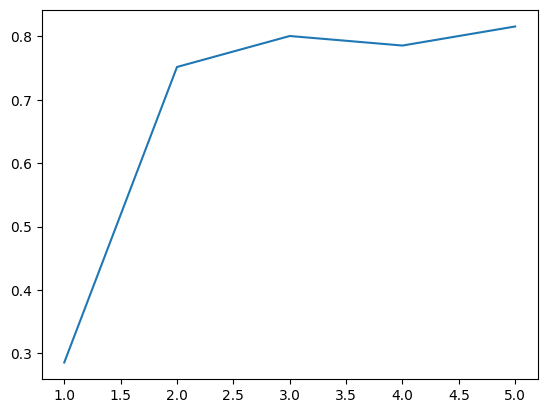

In [33]:
#CNN model train - reduced number of epochs
%matplotlib inline

EPOCHS = 5 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

Text(0, 0.5, 'Accuracy')

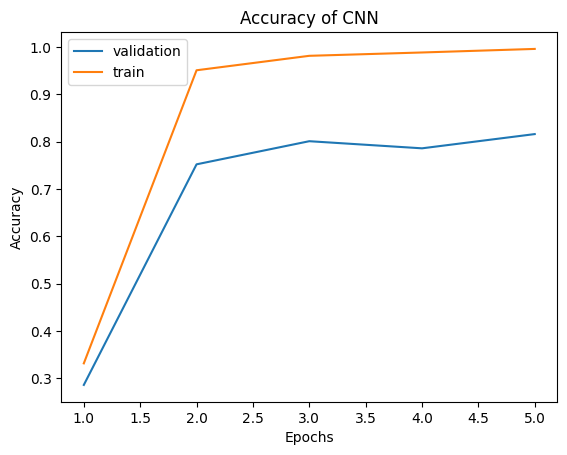

In [34]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Recall')

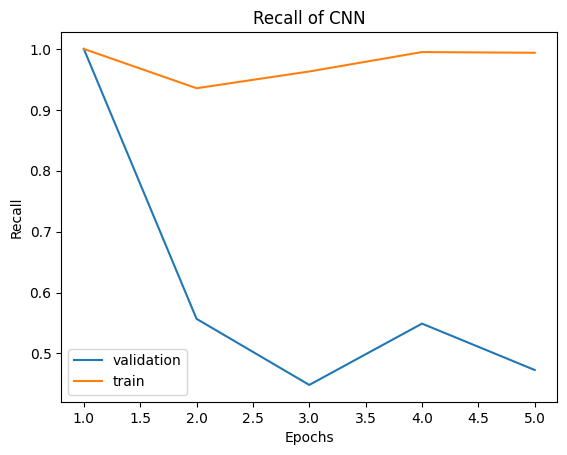

In [35]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')

Text(0, 0.5, 'Precision')

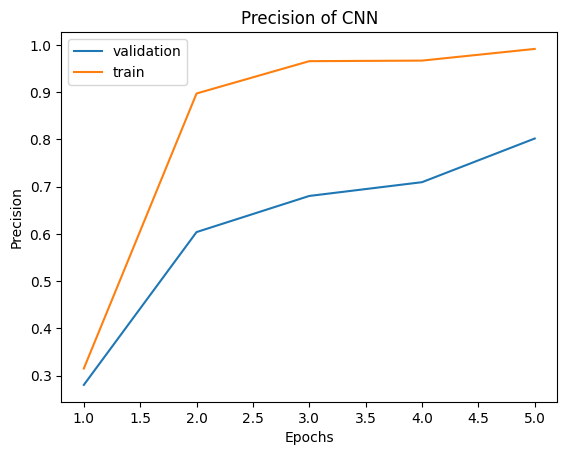

In [36]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')

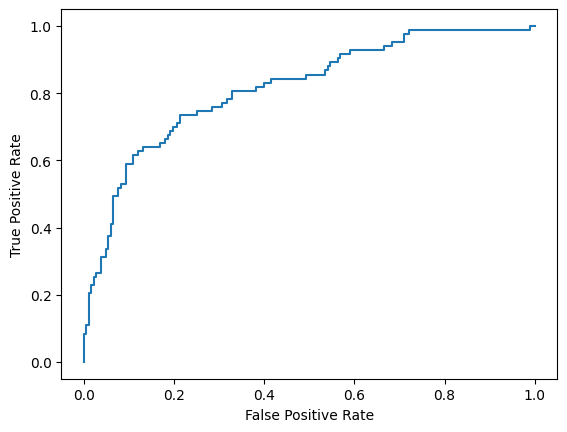

In [37]:
plot_roc_curve(y, y_prob)

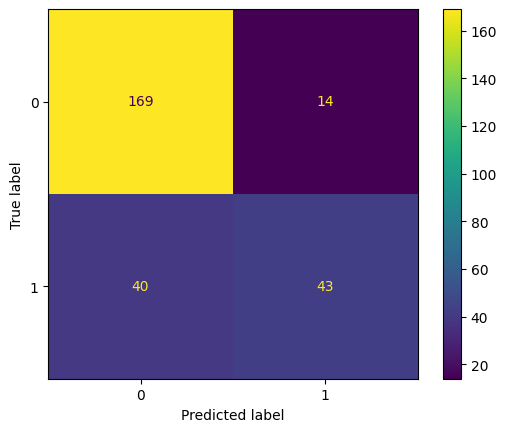

In [38]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()

In [39]:
model = CNNClassifier(embedding_dim = 64,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2,
                 dropout = 0.5)

At iteration 50 the loss is 11.042.
At iteration 100 the loss is 11.117.
Epoch: 1, time taken: 5.5s, validation accuracy: 
          0.575, recall: 0.6627917885780334, precision: 0.35387492179870605.
At iteration 50 the loss is 16.038.
At iteration 100 the loss is 24.344.
Epoch: 2, time taken: 5.5s, validation accuracy: 
          0.748, recall: 0.39808592200279236, precision: 0.5240195989608765.
At iteration 50 the loss is 21.613.
At iteration 100 the loss is 10.807.
Epoch: 3, time taken: 6.1s, validation accuracy: 
          0.778, recall: 0.4986461102962494, precision: 0.6098039150238037.
At iteration 50 the loss is 13.015.
At iteration 100 the loss is 12.647.
Epoch: 4, time taken: 5.8s, validation accuracy: 
          0.774, recall: 0.5394958257675171, precision: 0.5920167565345764.
At iteration 50 the loss is 15.185.
At iteration 100 the loss is 9.742.
Epoch: 5, time taken: 6.1s, validation accuracy: 
          0.801, recall: 0.46041083335876465, precision: 0.7149860262870789.
At 

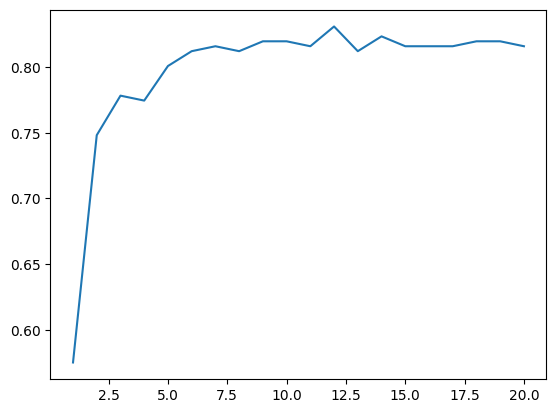

In [40]:
#CNN model train - 20 epochs with dropout of 0.5
%matplotlib inline

EPOCHS = 20 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

Text(0, 0.5, 'Accuracy')

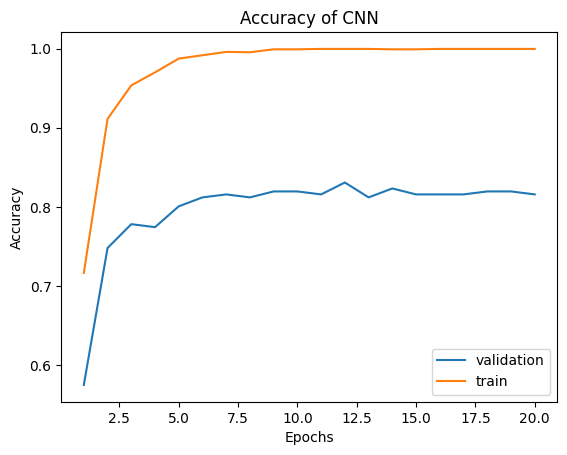

In [41]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Recall')

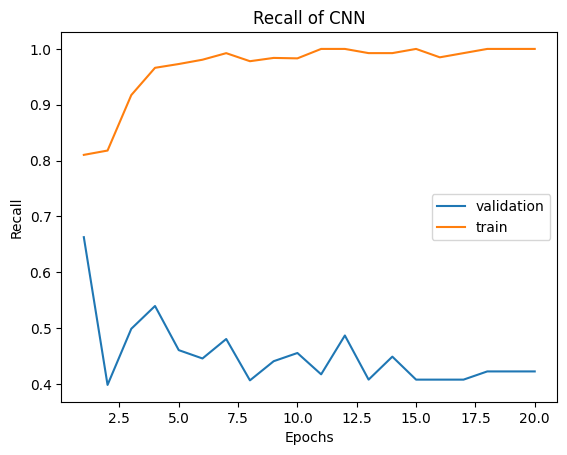

In [42]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')

Text(0, 0.5, 'Precision')

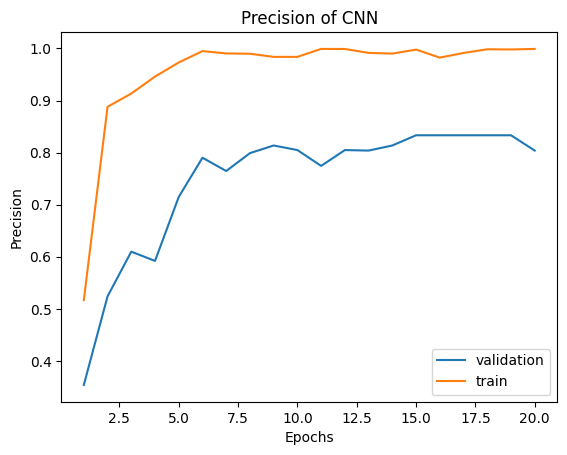

In [43]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')

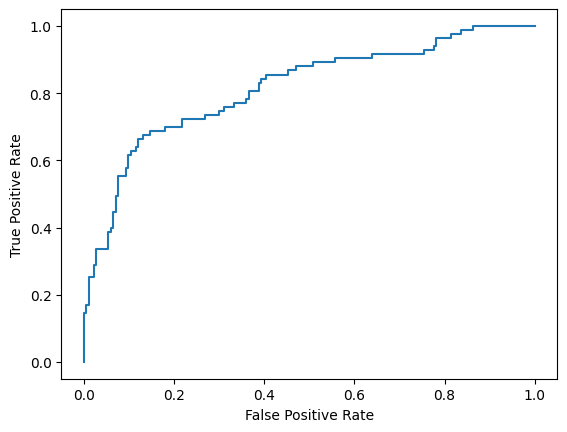

In [44]:
plot_roc_curve(y, y_prob)

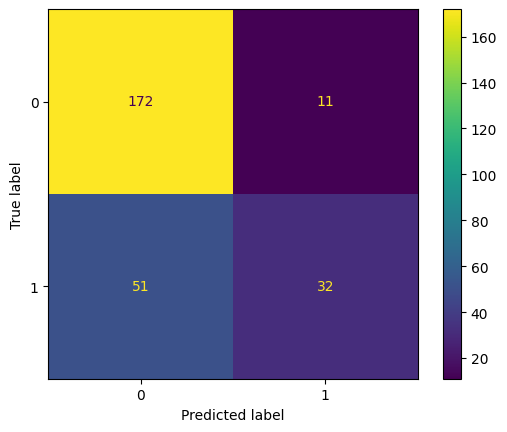

In [45]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()

In [34]:
model = CNNClassifier(embedding_dim = 64,
                 sequence_len = 500,
                 vocab_len = len(vocab), 
                 out_size = 32,
                 stride = 2,
                 dropout = 0.5)

At iteration 50 the loss is 22.449.
At iteration 100 the loss is 19.281.
Epoch: 1, time taken: 4.6s, validation accuracy: 
          0.568, recall: 0.4458683431148529, precision: 0.3340103030204773.
At iteration 50 the loss is 18.579.
At iteration 100 the loss is 13.541.
Epoch: 2, time taken: 5.0s, validation accuracy: 
          0.707, recall: 0.13641457259655, precision: 0.4166666865348816.
At iteration 50 the loss is 15.849.
At iteration 100 the loss is 23.753.
Epoch: 3, time taken: 4.8s, validation accuracy: 
          0.714, recall: 0.39089635014533997, precision: 0.48249301314353943.
At iteration 50 the loss is 13.367.
At iteration 100 the loss is 10.666.
Epoch: 4, time taken: 5.3s, validation accuracy: 
          0.722, recall: 0.38599440455436707, precision: 0.4864145815372467.
At iteration 50 the loss is 21.213.
At iteration 100 the loss is 15.231.
Epoch: 5, time taken: 4.7s, validation accuracy: 
          0.737, recall: 0.36442577838897705, precision: 0.5406162738800049.
At 

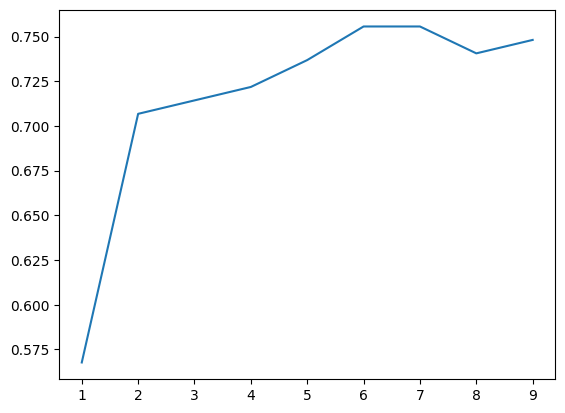

In [35]:
#CNN model train - 20 epochs with dropout of 0.5
%matplotlib inline

EPOCHS = 9 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracies_val = []
recalls_val = []
precisions_val = []
accuracies_train = []
recalls_train = []
precisions_train = []
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy_val, recall_val, precision_val = get_accuracy(valid_dataloader)
    accuracy_train, recall_train, precision_train = get_accuracy(train_dataloader)
    accuracies_val.append(accuracy_val)
    recalls_val.append(recall_val)
    precisions_val.append(precision_val)
    accuracies_train.append(accuracy_train)
    recalls_train.append(recall_train)
    precisions_train.append(precision_train)
    time_taken = time.time() - epoch_start_time
    print(f'''Epoch: {epoch}, time taken: {time_taken:.1f}s, validation accuracy: 
          {accuracy_val:.3f}, recall: {recall_val}, precision: {precision_val}.''')
    
plt.plot(range(1, EPOCHS+1), accuracies_val)

accuracy, recall, precision = get_accuracy(test_dataloader)
y, y_prob = get_probabilites(test_dataloader)
print(f'The estimated test accuracy is {accuracy:.3f}, recall {recall}, precision {precision}.')

Text(0, 0.5, 'Accuracy')

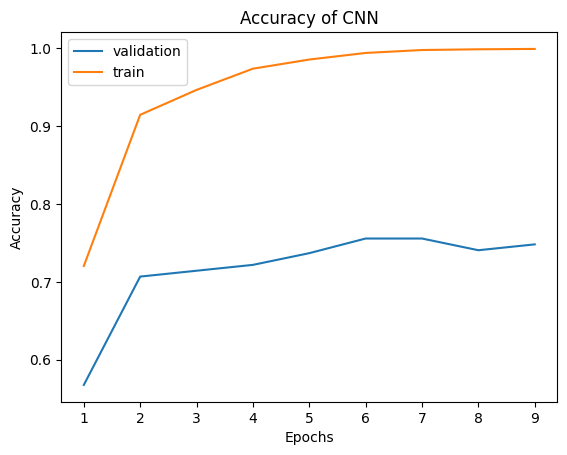

In [36]:
plt.plot(range(1, EPOCHS+1), accuracies_val, label='validation')
plt.plot(range(1, EPOCHS+1), accuracies_train, label='train')
plt.title('Accuracy of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Recall')

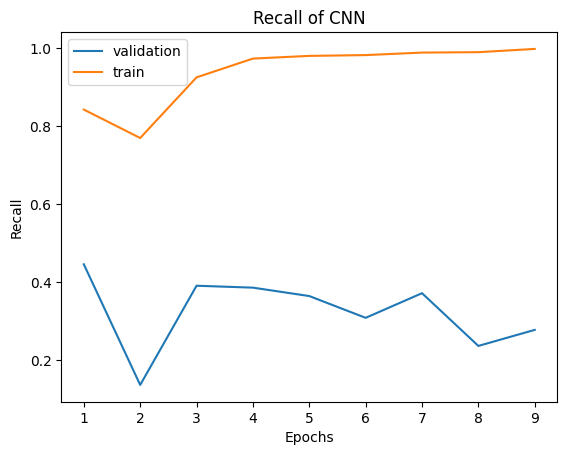

In [37]:
plt.plot(range(1, EPOCHS+1), recalls_val, label='validation')
plt.plot(range(1, EPOCHS+1), recalls_train, label='train')
plt.title('Recall of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Recall')


Text(0, 0.5, 'Precision')

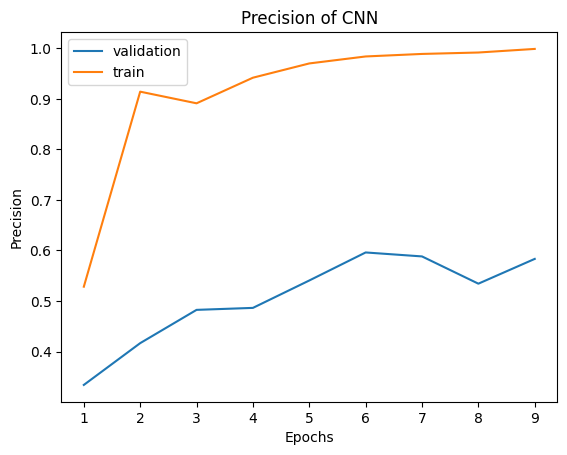

In [38]:
plt.plot(range(1, EPOCHS+1), precisions_val, label='validation')
plt.plot(range(1, EPOCHS+1), precisions_train, label='train')
plt.title('Precision of CNN')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Precision')


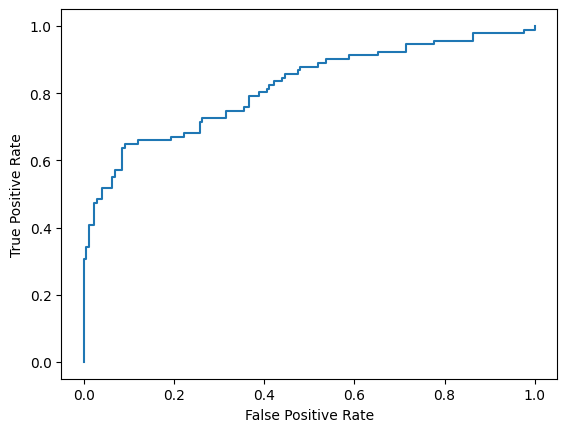

In [39]:
plot_roc_curve(y, y_prob)


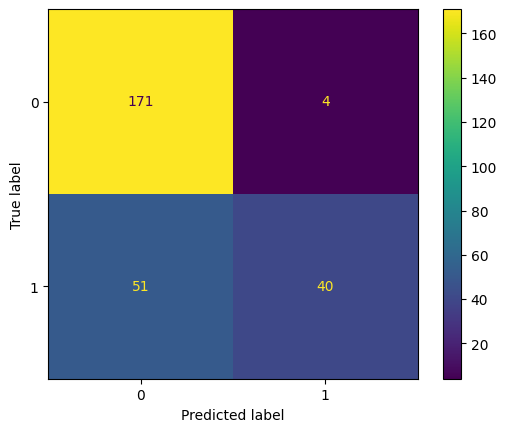

In [40]:
y_pred = [y.round() for y in y_prob]
cf_mat = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat)
disp.plot()
plt.show()